MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

## The goal is to take an image of a handwritten single digit, and determine what that digit is.
### For every digit in the test set, you should predict the correct label

# 1. Importation of libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import time
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import segmentation_models as sm

#neural layers
from tensorflow.keras import layers

Segmentation Models: using `tf.keras` framework.


In [2]:
#matplotlib defaults
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

## 2. Data Inception and formatting

In [3]:
train = pd.read_csv('C:/Users/PROFFESSOR/Desktop/MNIST/train.csv')
test  = pd.read_csv('C:/Users/PROFFESSOR/Desktop/MNIST/test.csv')

In [4]:
#snapshot on the training and test data shapes
train.shape, test.shape

((42000, 785), (28000, 784))

Code above shows that we have 42k rows of train and 28k rows of test rows.

In [6]:
#lets take a shapshot on the train data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#lets take a shape shot on the test data
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#preprocessing the datasets to obtain working train and test data as well as obtain the target label
trainX = (train.iloc[:,1:].values).astype('float32') # obtaining pixel values as features for each train data point
y_label = (train.iloc[:,0].values).astype('int32') # obtain the target  labels.
testX = test.values.astype('float32') # obtaining pixel values as features for each test data point

In [9]:
#new shapes of the data
trainX.shape, testX.shape, y_label.shape

((42000, 784), (28000, 784), (42000,))

From the code above, we can see that each of the 42k data points is a 28 * 28 pixel which also applies to the test dataset with similar pixel sizes.

In [10]:
#reshaping the target label
y_label = y_label.reshape(-1,1)
y_label.shape

(42000, 1)

In [11]:
#number of unique values in the target variable to be classified.
print("There are {} different labels in this dataset. ".format(len(np.unique(y_label))))
print("The labels are: {} ".format(np.unique(y_label)))

There are 10 different labels in this dataset. 
The labels are: [0 1 2 3 4 5 6 7 8 9] 


The above code shows us that we are going to deal with a multiclassification problem.

In [12]:
#convert train and test datasets to (num_images, img_rows, img_cols,1) format  where 1 is the color channel
trainX = trainX.reshape(trainX.shape[0], 28, 28,1)
testX = testX.reshape(testX.shape[0], 28, 28,1)

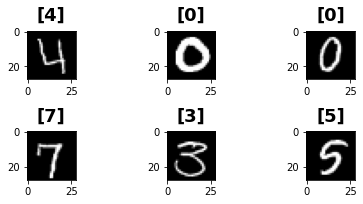

In [13]:
#sample data visualization
#Lets look at 6 images from data set with their labels
import warnings
warnings.filterwarnings("ignore")
#plt.subplots(330, sharex='col',sharey='row')
for i in range(3, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
    plt.title(y_label[i]);

# 3. Image preprocessing

Feature Standardization

For picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).
It is important preprocessing step. It is used to centre the data around zero mean and unit variance

In [14]:
train_set_x = trainX / 255
test_set_x = testX / 255

In [15]:
#One Hot encoding of labels
from tensorflow.keras.utils import to_categorical
train_labels= to_categorical(y_label)
num_classes = train_labels.shape[1]
num_classes

10

## 4. Model Building

In [16]:
from tensorflow.keras import Sequential
model = Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[28, 28, 1]),
    layers.Dropout(0.3),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.3),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(units=10, activation="softmax"),
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [18]:
from tensorflow.keras import optimizers
#optimizer=optimizers.Adam(epsilon=0.01)
model.compile(
    
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Model Training, Validation and Evaluation

In [19]:
#making splits to obtain data for cross validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_set_x, train_labels, test_size=0.20, random_state=1)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

### Case 1: Without Application of Data Augmentation

In [21]:
import time
start = time.process_time()
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],    
    verbose=0, # hide the output because we have so many epochs
)
end=time.process_time()

Best Validation Loss: 0.0297
Best Validation Accuracy: 0.9923
Computation time without data augmentation = 80.95520833333333 Mins


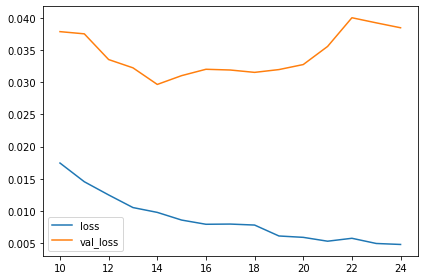

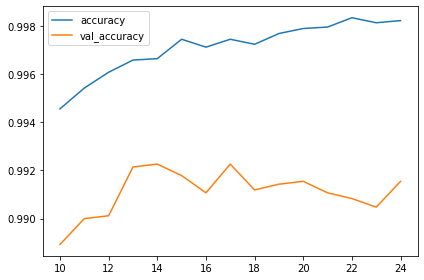

In [22]:
history_df1 = pd.DataFrame(history1.history) # 0.0370, .9907
# Start the plot at epoch 5
history_df1.loc[10:, ['loss', 'val_loss']].plot()
history_df1.loc[10:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df1['val_loss'].min(), 
              history_df1['val_accuracy'].max()))
print ("Computation time without data augmentation = " + str( (end - start)/60 ) + " Mins")

### Case 2: With Application of Data Augmentation

In [23]:
# With data augmentation to prevent overfitting and improve on generalization.

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [24]:
batch_size = 512
epochs = 1000

In [25]:
import time
start = time.process_time()
# Fit the model
history2 = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_valid, y_valid),
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              validation_steps= 100,
                              callbacks=[early_stopping],verbose=0) # hide the output because we have so many epochs)

end=time.process_time()

Instructions for updating:
Please use Model.fit, which supports generators.


Best Validation Loss: 0.0248
Best Validation Accuracy: 0.9937
Computation time with data augmentation = 86.14609375 Mins


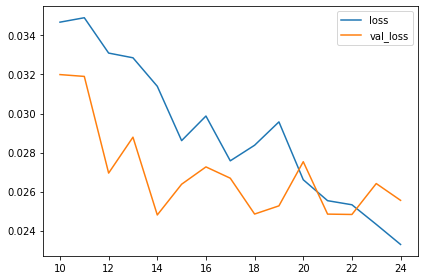

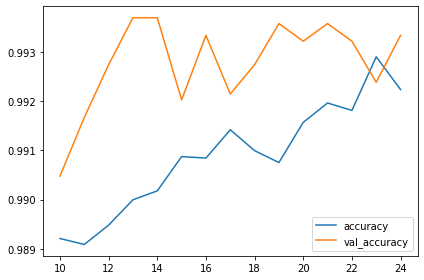

In [26]:
#Model performance
history_df2 = pd.DataFrame(history2.history) # 0.0264, .9942
# Start the plot at epoch 5
history_df2.loc[10:, ['loss', 'val_loss']].plot()
history_df2.loc[10:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df2['val_loss'].min(), 
              history_df2['val_accuracy'].max()))
print ("Computation time with data augmentation = " + str( (end - start)/60 ) + " Mins")

In [ ]:
#final predictions
predictions = model.predict_classes(test_set_x, verbose=0)

In [ ]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DIGIT_CLASSIFIER.csv", index=False, header=True)

In [ ]:
#Sample print
submissions.head().set_index('ImageId')